## LLM API call using OpenAI API

### Tools

In [9]:
from openai import OpenAI
import os
import base64

# for plotting images
import matplotlib.pyplot as plt
from PIL import Image

### OpenAI client setup

In [2]:
# Use environment variables
key = os.getenv("OPENAI_API_KEY")
org_id = os.getenv("OPENAI_ORG_ID")

# construct client instance
client = OpenAI(api_key=key,
                organization=org_id)

### Data

`*user_sample_path*` is where a sample used for prediction is stored. For now, a random image from the internet (of a likely melanoma) is used to test the system.

`*xia_gradcam_output_path*` and `*xia_shap_output_path*` refer to the locations where xai output images are stored. Currently, I am using test images generated with ChatGPT.

`*xai_influence_output_path*` is where a mock output from the influence function is stored. Actual output should rank scores for training cases (samples) from the most to the least influencial for the current prediction. For our survey we can present 10 top influencial, but for LLM call we could pass more (50-100), the model can then run some statistical analysis.   


In [3]:
user_sample_path = os.path.join(os.getcwd(), '../data/user_data/user_sample1.jpeg')
xai_gradcam_output_path = os.path.join(os.getcwd(), '../data/xai_output/user_sample1_xai_gradcam.png')
xai_shap_output_path = os.path.join(os.getcwd(), '../data/xai_output/user_sample1_xai_shap.png')
xai_influence_output_path = os.path.join(os.getcwd(), '../data/xai_output/user_sample1_influence_function.txt')

user_sample_probs = [0.78, 0.22] # mock probabilities output by the model for the user_sample 1, i.e., 0.78 for Malignant and  0.22 for Benign.

In [4]:
# Function to encode the images to base64 byte objects in string format
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# encode the xai output images
xai_gradcam_enc = encode_image(xai_gradcam_output_path)
xai_shap_enc = encode_image(xai_shap_output_path)

# Read in the influence function output
with open(xai_influence_output_path, "r", encoding="utf-8") as f:
    xai_influence_function = f.read()

### Instructions

In constructing the instructions for LLM, I've followed OpenAI's best prompting practices available [here](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)

In [21]:
# read in the instructions
with open(os.path.join(os.getcwd(), "../data/llm_instructions.md"), "r", encoding="utf-8") as f:
    instructions = f.read()

### LLM API call

We use a flagship model from OpenAI, GPT-4.1 (model snapshot: 2025-04-14). According to the company's documentation, it is highly capable at complex task while expressing strict adherance to instructions.  

In [22]:
response = client.responses.create(
    model="gpt-4.1-2025-04-14",
    input=[
        {
            "role": "developer",
            "content" : instructions
        },
        {
            "role": "user",
            "content": [
                { 
                    "type": "input_text",
                    "text": str(user_sample_probs) },
                { 
                    "type": "input_text",
                    "text": xai_influence_function },
                    
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_gradcam_enc}",
                    "detail": "auto"
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_shap_enc}",
                    "detail": "auto"
                },

            ],
        }
    ],
)

print(response.output_text)

**Summary**

The AI analysis suggests high concern for malignancy in this skin lesion.

**Confidence Level**

The model is 78% confident, meaning there's still a 22% chance this assessment could be incorrect.

**Key Findings**

- GradCAM: The heat map shows the AI paid closest attention to the bright red area in the centre of the image when making its prediction, which suggests that this part of the image had the most influence on the decision.
- SHAP: The analysis highlights a strong dark red area in the centre, with some lighter red nearby. These features strongly pushed the decision toward malignancy according to the model, and the focus area matches what GradCAM identified.
- Both GradCAM and SHAP visualisations are focused on the same central region, supporting that the most influential parts for the model’s decision were consistent.
- Influence Function: 76% of the most influential training cases were similar to this analysis and labeled as malignant, while 24% were labeled as be

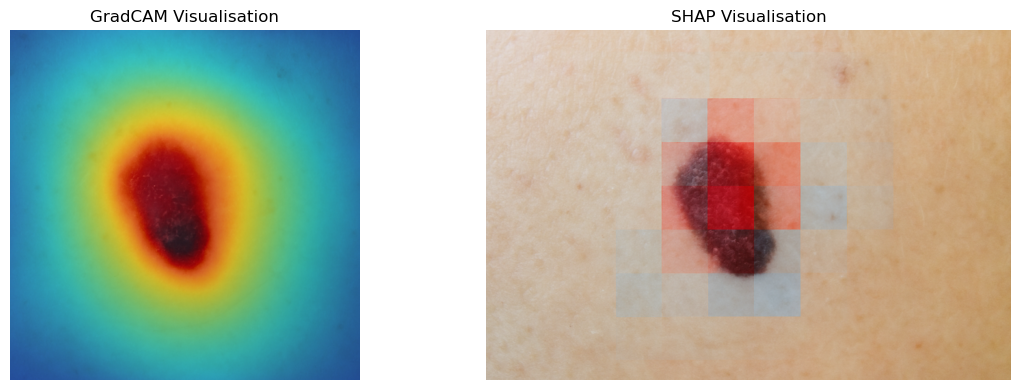

In [13]:
# Load and display xai images for context
img1 = Image.open(xai_gradcam_output_path)
img2 = Image.open(xai_shap_output_path)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('GradCAM Visualisation')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('SHAP Visualisation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
